# Density Modelling with Context Tree Switching

[In the first tutorial](text_prediction_tutorial.ipynb) we looked at predicting a sequence of text using CTS. Here we use it for a different purpose: density modelling. Rather than text, we will be modelling Atari 2600 images. This particular model is by no means a state of the art density model; however, its high statistical efficiency makes it a useful addition to any modelling toolkit.

## Sequential Density Modelling

Although context tree-based approaches are best suited to predicting sequences of atomic symbols, such as bits or text, we've also successfully used them for image and video prediction in [Atari 2600 games](http://www.arcadelearningenvironment.org). In two papers (on the [Quad-Tree Factorization (2013)](http://www.marcgbellemare.info/static/publications/bellemare13bayesian.pdf) and on [Skip CTS (2014)](http://www.marcgbellemare.info/static/publications/bellemare14skip.pdf)) we described models that predict frames using the same principles as the CTS model. We've also used these models for [value function approximation in reinforcement learning (2015)](http://www.marcgbellemare.info/static/publications/veness15compress.pdf) and recently, to design [intrinsically motivated agents (2016)](https://arxiv.org/abs/1606.01868).

While the first two papers learn dynamical models of Atari frames (predicting observation $x_t$ from $x_{t-1}$, $x_{t-2}, \dots$) the latter two learn *density models* of the same. In this case, we assign a probability to $x_t$ to reflect the empirical frequency of observed frames. By analogy to the text setting, a density model is a dynamical model with a context length of 0. In other words, we view frames as sequence of i.i.d. data and ignore the temporal dependencies. However, since we're now predicting whole frames, each composed of $210 \times 160$ pixels, density modelling is not necessarily trivial. Consider the following frame from *Freeway*:

![A frame from *Freeway*.](images/freeway-screen.png)

The high-level structure of Freeway guarantees that each image contains exactly ten cars, two chickens, two score indicators, and one Activision logo. The emulator will never output a frame with twenty-one cars or no chickens. A good density model should reflect this knowledge, and assign a significantly lower probability to the latter. This point will become clearer as we consider models of increasing complexity in the following sections.

(An aside: a density model really is a [generative model](https://en.wikipedia.org/wiki/Generative_model), but I've avoided that name here because "generative model" has come to include algorithms that don't output probabilities, such as some of the most recent neural network models.)

Our data set for this example consists of 240,827 distinct frames, although we'll use a tiny subset for training: for most of the examples in this tutorial we'll train on 20 images.

## Setup

Let's start with some imports and helper functions. To get this to work, you may need to install the following Python libraries:
* Matplotlib
* Scipy
* Pillow

In [1]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc
import sys
import time

import cts.model as model

Now that we're dealing with images, there's a little more processing involved. These methods will let us convert between RGB triples and the integer-valued symbols CTS expects.

In [2]:
def rgb_to_symbol(channels):
    """Converts an RGB triple into an atomic colour (24-bit integer).
    """
    return (channels[0] << 16) | (channels[1] << 8) | (channels[2] << 0)

def symbol_to_rgb(colour):
    """Inverse operation of rgb_to_symbol.
    
    Returns: a (r, g, b) tuple.
    """
    return (colour >> 16, (colour >> 8) & 0xFF, (colour >> 0) & 0xFF)

def rgb_to_symbols(frame, output):
    """Preprocesses the given frame into a CTS-compatible representation.
    """
    assert(frame.shape[:2] == output.shape)
    for y in range(frame.shape[0]):
        for x in range(frame.shape[1]):
            output[y, x] = rgb_to_symbol(frame[y, x])

    return output

def symbols_to_rgb(frame, output):
    """Inverse of rgb_to_symbols.
    """
    assert(frame.shape == output.shape[:2])
    for y in range(frame.shape[0]):
        for x in range(frame.shape[1]):
            output[y, x] = symbol_to_rgb(frame[y, x])

    return output

Finally, a wrapper method that will load Freeway frames from disk and serve them to us.

In [3]:
def freeway_generator(start_frame=0, max_frames=-1):
    """Generator of Freeway frames.
    
    Args:
        start_frame: The starting frame. Frames prior to this one are discarded.
        max_frames: Maximum number of frames to return. If -1, return all frames.
    """
    frame_counter = 0
    if max_frames >= 0:
        end_frame = start_frame + max_frames

    for filename in glob.glob('freeway-frames/*.png'):
        if frame_counter < start_frame:
            frame_counter += 1
            continue
        elif max_frames >= 0 and frame_counter >= end_frame:
            return
        else:
            frame_counter += 1
            yield misc.imread(filename)

We'll need the shape of the frame in a number of places. Let's determine it here.

In [4]:
FRAME_SHAPE = next(freeway_generator(0, 1)).shape
print ('Frame shape is {}'.format(FRAME_SHAPE))

Frame shape is (210, 320, 3)


### "Chicken and Tar Soup"
To learn a density over frames, we will embed CTS within a larger model. Let's start by predicting each pixel independently (modelling the marginal colour distribution), using a single convolutional pixel model.

In [5]:
class ConvolutionalMarginalDensityModel(object):
    """A density model for Freeway frames."""
    def __init__(self, frame_shape):
        """Constructor.
        
        Args:
            init_frame: A sample frame (numpy array) from which we determine the shape and type of our data.
        """
        self.convolutional_model = model.CTS(context_length=0)
        self.frame_shape = frame_shape
        
    def update(self, frame):
        assert(frame.shape == self.frame_shape)
        
        total_log_probability = 0.0
        # We simply apply the CTS update to each pixel.
        for y in range(frame.shape[0]):
            for x in range(frame.shape[1]):
                # Convert all 3 channels to an atomic colour.
                colour = rgb_to_symbol(frame[y, x])
                total_log_probability += self.convolutional_model.update(context=[], symbol=colour)

        return total_log_probability

    def sample(self):
        output_frame = np.zeros(self.frame_shape, dtype=np.uint8)

        for y in range(output_frame.shape[0]):
            for x in range(output_frame.shape[1]):
                # Use rejection sampling to avoid generating non-Atari colours.
                colour = self.convolutional_model.sample(context=[], rejection_sampling=True)
                output_frame[y, x] = symbol_to_rgb(colour)
        
        return output_frame

Let's see how long it takes to process twenty full 210x320x3 frames.

In [6]:
def train_freeway_density_model(model, num_frames):
    start_time = time.time()
    total_log_probability = 0.0
    
    sys.stdout.write ('Training on {} frames '.format(num_frames))
    for frame in freeway_generator(start_frame=0, max_frames=num_frames):
        total_log_probability += model.update(frame)
        sys.stdout.write ('.')
    sys.stdout.write('\n')

    print ('Training time: {:.1f} seconds'.format(time.time() - start_time))
    print ('Loss (in bytes per frame): {:.2f}'.format(-total_log_probability / math.log(2) / 8 / num_frames))

In [7]:
convolutional_marginal_model = ConvolutionalMarginalDensityModel(frame_shape=FRAME_SHAPE)

train_freeway_density_model(convolutional_marginal_model, num_frames=20)

Training on 20 frames ....................
Training time: 14.1 seconds
Loss (in bytes per frame): 11588.37


This is a little slower than we'd like. In our papers we've proposed a number of different ways to improve prediction speed, ranging from downsampling (also typically used with neural networks) to predicting whole image patches at a time. In fact, raw Atari 2600 frames begin their life in 210x160, and are only stretched for display purposes (for an excellent book on the inner workings of the Atari 2600, I recommend [*Racing the Beam* by Montfort and Bogost](https://mitpress.mit.edu/books/racing-beam)). For now, though, we'll work with what we have.

By the way, 11588 bytes per frame is awful. PNG compression achieves, on these 20 frames, an average of 1268 bytes per frame. That's including the header. But let's not worry too much for now, and let's see what model samples might look like.

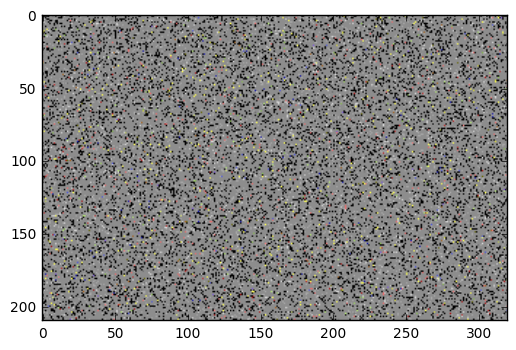

In [8]:
sampled_frame = convolutional_marginal_model.sample()

plt.imshow(sampled_frame)
plt.show()

I'll call this one "Chicken and Tar Soup". Our first model doesn't consider position, nor does it consider neighbouring pixels. The result is a sample drawn from the marginal distribution over colours: bits of car paint and feathers stirred in a pot of grey asphalt. The black pixels come from the border surrounding the play area.

You can convince yourself that these are actual samples by the re-running the code a number of times. See how the little red dots keep shifting around?

### Contextual predictions.
To improve on the above model, we'll provide some context for each prediction. Unlike text prediction, where the past $k$ symbols formed our context, we will simply think of it as an arbitrary vector given to us by the larger model. We do need to be careful and respect the chain rule, however: there must exist a total ordering in which each pixel's probability only depends on earlier pixels. Here we enforce this by predicting pixels in row-major order, and using a L-shaped neighbourhood as our context:

![The L-shaped context.](images/filter.png)

In [9]:
def L_shaped_context(image, y, x):
    """This grabs the L-shaped context around a given pixel.
    
    Out-of-bounds values are set to 0xFFFFFFFF."""
    context = [0xFFFFFFFF] * 4
    if x > 0:
        context[3] = image[y][x - 1]
    
    if y > 0:
        context[2] = image[y - 1][x]
        context[1] = image[y - 1][x - 1] if x > 0 else 0
        context[0] = image[y - 1][x + 1] if x < image.shape[1] - 1 else 0

    # The most important context symbol, 'left', comes last.
    return context

class ConvolutionalDensityModel(object):
    """A density model for Freeway frames.
    
    This one predict according to an L-shaped context around the current pixel.
    """
    def __init__(self, frame_shape, context_functor, alphabet=None):
        """Constructor.
        
        Args:
            init_frame: A sample frame (numpy array) from which we determine the shape and type of our data.
            context_functor: Function mapping image x position to a context.
        """
        # For efficiency, we'll pre-process the frame into our internal representation.
        self.symbol_frame = np.zeros((frame_shape[0], frame_shape[1]), dtype=np.uint32)

        context_length = len(context_functor(self.symbol_frame, -1, -1))
        self.convolutional_model = model.CTS(context_length=context_length, alphabet=alphabet)
        
        self.context_functor = context_functor

    def update(self, frame):
        rgb_to_symbols(frame, self.symbol_frame)
        
        total_log_probability = 0.0
        for y in range(self.symbol_frame.shape[0]):
            for x in range(self.symbol_frame.shape[1]):
                context = self.context_functor(self.symbol_frame, y, x)
                colour = self.symbol_frame[y, x]
                total_log_probability += self.convolutional_model.update(context=context, symbol=colour)

        return total_log_probability

    def sample(self):
        output_frame = np.zeros((*self.symbol_frame.shape, 3), dtype=np.uint8)
        print (output_frame.shape)
        
        for y in range(self.symbol_frame.shape[0]):
            for x in range(self.symbol_frame.shape[1]):
                # From a programmer's perspective, this is why we must respect the chain rule: otherwise
                # we condition on garbage.
                context = self.context_functor(self.symbol_frame, y, x)
                self.symbol_frame[y, x] = self.convolutional_model.sample(context=context,
                                                                          rejection_sampling=True)

        return symbols_to_rgb(self.symbol_frame, output_frame)

    def sample_with_update(self):
        output_frame = np.zeros((*self.symbol_frame.shape, 3), dtype=np.uint8)
        print (output_frame.shape)
        
        for y in range(self.symbol_frame.shape[0]):
            for x in range(self.symbol_frame.shape[1]):
                context = self.context_functor(self.symbol_frame, y, x)
                self.symbol_frame[y, x] = self.convolutional_model.sample(context=context,
                                                                          rejection_sampling=False)
                self.convolutional_model.update(context, self.symbol_frame[y, x])
    
        return symbols_to_rgb(self.symbol_frame, output_frame)

In [10]:
convolutional_model = ConvolutionalDensityModel(frame_shape=(210, 320, 3), context_functor=L_shaped_context)
train_freeway_density_model(convolutional_model, num_frames=20)

Training on 20 frames ....................
Training time: 42.3 seconds
Loss (in bytes per frame): 673.74


This new model is slow enough to make me want to switch back to C++. Is the context worth it? Looking back at the convolutional marginal model, our loss per frame was 11588, with PNG giving us a cool 1268. It's quite reassuring then to know that our ultra-efficient model, with its 673.7 bytes per frame, manages to beat PNG. It's a bit like swatting a fly with a cricket bat.

Note, however, that the PNG doesn't get to train on multiple frames. Try setting num_frames to 1, and you'll see the loss go up to 937. Still better than PNG.

(210, 320, 3)


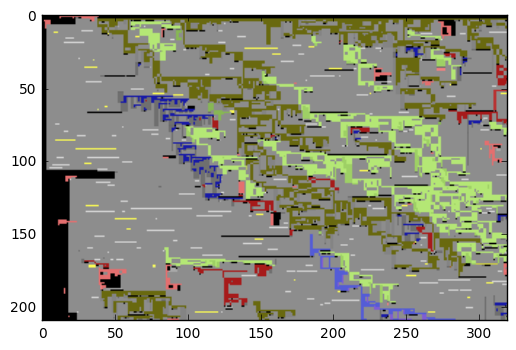

In [11]:
sampled_frame = convolutional_model.sample()

plt.imshow(sampled_frame)
plt.show()

If this model gets any better it'll get its own abstract art installation. Notice how you can pick out the L-shaped context from on the blockiness of the generated shapes and black border.

Sampling from the contextual model is a little faster than training it. This is because at training time we update all the models corresponding to a context's suffix. When sampling, we pick one such model according to the CTS posterior. We also don't have to update the posterior itself, which requires a number of costly log-space operations. However, rejection sampling carries an extra computational cost.

### A better context.

Let's carry the above experiment further and define a context based on the idea of dilations, which have made a [recent resurgence in deep learning](https://arxiv.org/pdf/1609.03499v2.pdf). Dilations extend the spatial coherence between pixels relatively cheaply. The equivalent filter (with strides 1, 2, 4, 8) looks like this:

![The dilations L-shaped context.](images/filter-dilations.png)

In [12]:
def dilations_context(image, y, x):
    """Generates a dilations-based context.
    
    We successively dilate first to the left, then up, then diagonally, with strides 1, 2, 4, 8, 16.
    """
    SPAN = 5
    # Default to -1 context.
    context = [0xFFFFFFFF] * (SPAN * 3)
    
    min_x, index = 1, (SPAN * 3) - 1
    for i in range(SPAN):
        if x >= min_x:
            context[index] = image[y][x - min_x]
        index -= 3
        min_x = min_x << 1

    min_y, index = 1, (SPAN * 3) - 2
    for i in range(SPAN):
        if y >= min_y:
            context[index] = image[y - min_y][x]
        index -= 3
        min_y = min_y << 1

    min_p, index = 1, (SPAN * 3) - 3
    for i in range(SPAN):
        if x >= min_p and y >= min_p:
            context[index] = image[y - min_p][x - min_p]
        index -= 3
        min_p = min_p << 1

    return context

In [13]:
convolutional_dilations_model = ConvolutionalDensityModel(frame_shape=(210, 320, 3), context_functor=dilations_context)
train_freeway_density_model(convolutional_dilations_model, num_frames=20)

Training on 20 frames ....................
Training time: 125.3 seconds
Loss (in bytes per frame): 238.33


238 bytes after training on only 20 frames isn't bad at all. 

(210, 320, 3)


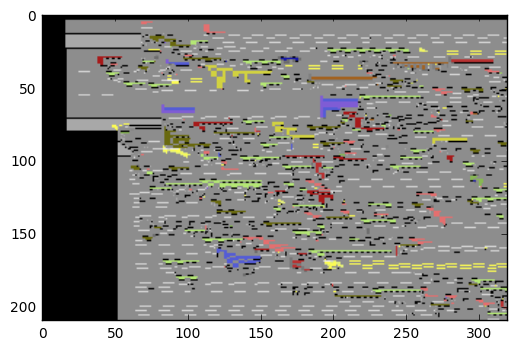

In [14]:
sampled_frame = convolutional_dilations_model.sample()

plt.imshow(sampled_frame)
plt.show()

We're finally getting somewhere: the left-hand border is present, and we can see lines on the road (painted by an amnesiac road worker). Still, this is a far cry from the present state of the art. The issue is that our model focuses too much on the details, and too little on the general structure.

### Miscellaneous improvements.

There are two easy ways to improve our model which we'll now look at:
- Use one model for each pixel location
- Downsample the frames

We could improve on the first solution even further by considering a mixture with a background model, but we won't go there today.

In [15]:
class LocationDependentDensityModel(object):
    """A density model for Freeway frames.
    
    This is exactly the same as the ConvolutionalDensityModel, except that we use one model for each
    pixel location.
    """
    def __init__(self, frame_shape, context_functor, alphabet=None):
        """Constructor.
        
        Args:
            init_frame: A sample frame (numpy array) from which we determine the shape and type of our data.
            context_functor: Function mapping image x position to a context.
        """
        # For efficiency, we'll pre-process the frame into our internal representation.
        self.symbol_frame = np.zeros((frame_shape[0:2]), dtype=np.uint32)

        context_length = len(context_functor(self.symbol_frame, -1, -1))
        self.models = np.zeros(frame_shape[0:2], dtype=object)
        
        for y in range(frame_shape[0]):
            for x in range(frame_shape[1]):
                self.models[y, x] = model.CTS(context_length=context_length, alphabet=alphabet)
        
        self.context_functor = context_functor

    def update(self, frame):
        rgb_to_symbols(frame, self.symbol_frame)
        
        total_log_probability = 0.0
        for y in range(self.symbol_frame.shape[0]):
            for x in range(self.symbol_frame.shape[1]):
                context = self.context_functor(self.symbol_frame, y, x)
                colour = self.symbol_frame[y, x]
                total_log_probability += self.models[y, x].update(context=context, symbol=colour)

        return total_log_probability

    def sample(self):
        output_frame = np.zeros((*self.symbol_frame.shape, 3), dtype=np.uint8)
        print (output_frame.shape)
        
        for y in range(self.symbol_frame.shape[0]):
            for x in range(self.symbol_frame.shape[1]):
                # From a programmer's perspective, this is why we must respect the chain rule: otherwise
                # we condition on garbage.
                context = self.context_functor(self.symbol_frame, y, x)
                self.symbol_frame[y, x] = self.models[y, x].sample(context=context, rejection_sampling=True)

        return symbols_to_rgb(self.symbol_frame, output_frame)

As usual, let's train the model then sample.

In [16]:
location_dependent_model = LocationDependentDensityModel(frame_shape=(210, 320, 3), context_functor=dilations_context)
train_freeway_density_model(location_dependent_model, num_frames=20)

Training on 20 frames ....................
Training time: 145.5 seconds
Loss (in bytes per frame): 5763.82


(210, 320, 3)


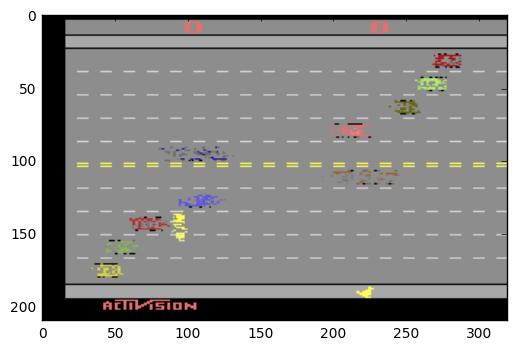

In [17]:
sampled_frame = location_dependent_model.sample()

plt.imshow(sampled_frame)
plt.show()

Don't be fooled by this model's good looks: the log probability suggests it's actually far worse at prediction than the convolutional model. Still, location-dependent predictions allow us to almost immediately get the background right. Remember, the sample looks quite good because we're using rejection sampling.

Let's also look at the effect of downsampling, this time without the location-dependent model. Downsampling is a reasonable preprocessing step if we are mostly interested in the relative densities of frames. In fact, the images we've been using so far are double their original width! Atari 2600 frames normally come in 160x210.

Note that the log probabilities of downsampled frames are not comparable to those of full frames.

In [18]:
def get_frame_alphabet(num_frames, frame_shape=None):
    """Returns the set of distinct pixel values observed in downsampled frames.
    """
    alphabet = set()
    
    for frame in freeway_generator(start_frame=0, max_frames=num_frames):        
        if frame_shape is not None:
            frame = misc.imresize(frame, frame_shape, 'bilinear')
            
        symbols = np.zeros(frame.shape[:2], dtype=np.uint32)
        symbols = rgb_to_symbols(frame, symbols)

        alphabet = alphabet.union(set(np.unique(symbols)))
    
    return alphabet

In [19]:
def train_downsampled_model(model, num_frames):
    start_time = time.time()
    total_log_probability = 0.0
    
    sys.stdout.write ('Training on {} frames '.format(num_frames))
    for frame in freeway_generator(start_frame=0, max_frames=num_frames):
        frame = misc.imresize(frame, (105, 80), 'bilinear')
        total_log_probability += model.update(frame)
        sys.stdout.write ('.')
    sys.stdout.write('\n')

    print ('Training time: {:.1f} seconds'.format(time.time() - start_time))
    print ('Loss (in bytes per frame): {:.2f}'.format(-total_log_probability / math.log(2) / 8 / num_frames))

We need to figure out the proper alphabet here, which is bigger than for the original frames as we average colour values. From a compression point of view, though, this is cheating!

In [20]:
num_frames = 20
frame_shape = (105, 80)
alphabet = get_frame_alphabet(num_frames, frame_shape)
downsampled_model = ConvolutionalDensityModel(frame_shape=frame_shape + (3,), context_functor=dilations_context,
                                              alphabet=alphabet)

train_downsampled_model(downsampled_model, num_frames)

Training on 20 frames ....................
Training time: 16.5 seconds
Loss (in bytes per frame): 198.60


Bonus: training on downsampled frames is much faster.

(105, 80, 3)


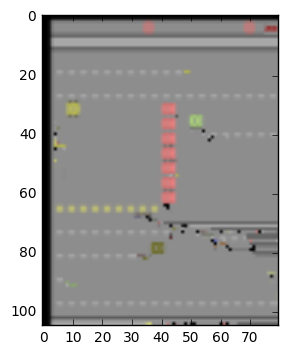

In [21]:
sampled_frame = downsampled_model.sample()

plt.imshow(sampled_frame)
plt.show()

And it looks better, too! At least, some samples do. Each pixel in the downsampled image effectively corresponds to a larger portion of the image. This mean both our predictions and — more importantly — our contexts have wider receptive fields.

In [our earlier work on the Quad-Tree Factorization (QTF)](http://www.marcgbellemare.info/static/publications/bellemare13bayesian.pdf) we demonstrated how to learn a variable resolution structure, allowing ourselves to predict large image patches atomically. For example, the static banner at the top of the frame need not be predicted at the pixel level, since it never changes. This is the result after 20 frames of training:

![Sample from the QTF model](images/qtf-sample.png)

By predicting in large patches, the algorithm can more easily model objects and global structure. However, we won't go further into this algorithm today.

### Sampling from the prior.

To conclude this notebook, let's sample from the prior defined by our model. For text prediction, this prior produced proto-language samples. Similarly, one would expect that a good image prior produces proto-visuals, in particular containing texture. Unfortunately, this isn't really the case. If such a prior exists, what would it look like? We'll leave this as an open question.

We cheated a little when generating samples in the examples above. Specifically, we should have updated our convolutional models after sampling each pixel to reflect how the training proceeds. If we don't do this when sampling from the prior, we'll get pure random noise. Conveniently, `sample_with_update()` is already included in `ConvolutionalDensityModel`.

(100, 100, 3)


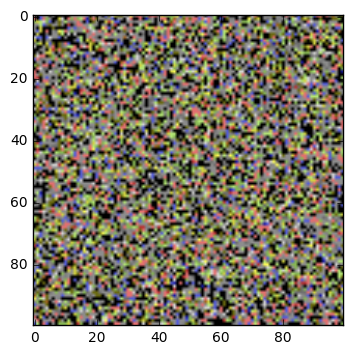

In [22]:
# Obtain alphabet needed to generate samples.
freeway_frame = next(freeway_generator(start_frame=0, max_frames=1))
symbols = np.zeros(freeway_frame.shape[:2], dtype=np.uint32)
symbols = rgb_to_symbols(freeway_frame, symbols)

alphabet = set(np.unique(symbols))

prior_dilations_model = ConvolutionalDensityModel(frame_shape=(100, 100, 3),
                                                  context_functor=dilations_context,
                                                  alphabet=alphabet)

sampled_frame = prior_dilations_model.sample_with_update()

plt.imshow(sampled_frame)
plt.show()

Can make out any structure in this sample? I certainly can't. In fact, here's a sample from a marginal model. It's hard to tell the two apart. You need to generate a good deal of samples from the contextual model before something slightly more structured comes up.

(100, 100, 3)


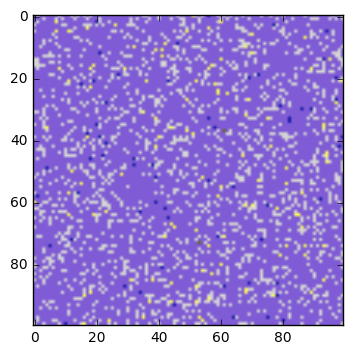

In [23]:
marginal_model = ConvolutionalDensityModel(frame_shape=(100, 100, 3),
                                           context_functor=lambda frame, y, x: [],
                                           alphabet=alphabet)

plt.imshow(marginal_model.sample_with_update())
plt.show()

That's it for us. Questions, comments, suggestions? Please let us know.